In [1]:
# # Phase 5C.1: Operational Limit Reliability & Workability Forecast
#
# **Objective**: Quantify the **Workability %** (P50, P80, P90) and **Project Reliability** for specific operations on a month-by-month basis.
#
# **The "Super" Upgrade:**
# - **Real Data Calibration:** Uses monthly statistics from the 10-year dataset.
# - **Hourly Physics:** Simulates tidal windows and weather downtime at hourly resolution.
# - **Probabilistic Workability:** Instead of a single "Average Workability," we calculate the P50 (Typical), P80 (Conservative), and P90 (Worst-Case) workability for each month.
#
# **Why This Matters:**
# - "Average" workability hides the risk. A month with 50% average workability might have years with only 20%.
# - This notebook tells you: "Plan for 45% workability (P50), but budget for 30% (P90)."
#
# ---

In [2]:
# ## PART 1: SETUP & DATA CALIBRATION

# ### Cell 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, lognorm
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('viridis')
pd.set_option('display.precision', 1)

print("✅ Imports complete")

✅ Imports complete


In [3]:

print("="*80)
print("CALIBRATING MODEL WITH REAL DATA")
print("="*80)

df_real = pd.read_parquet('../data/processed/timeseries/UK_NortheastCoast_2015_2025_complete.parquet')

# --- FIX: Ensure Index is Datetime ---
if 'time' in df_real.columns:
    df_real['time'] = pd.to_datetime(df_real['time'])
    df_real.set_index('time', inplace=True)
# -------------------------------------

df_real['month'] = df_real.index.month

# Calculate Monthly Stats for Simulation
monthly_stats = {}
for m in range(1, 13):
    data = df_real[df_real['month'] == m]
    monthly_stats[m] = {
        'hs_mu': np.log(data['hs'].mean()) - 0.5 * np.log(1 + (data['hs'].std()/data['hs'].mean())**2),
        'hs_sigma': np.sqrt(np.log(1 + (data['hs'].std()/data['hs'].mean())**2)),
        'wind_mu': np.log(data['wind_speed'].mean()) - 0.5 * np.log(1 + (data['wind_speed'].std()/data['wind_speed'].mean())**2),
        'wind_sigma': np.sqrt(np.log(1 + (data['wind_speed'].std()/data['wind_speed'].mean())**2))
    }

print("✅ Monthly statistics calibrated.")

CALIBRATING MODEL WITH REAL DATA
✅ Monthly statistics calibrated.


In [4]:
# ## PART 2: THE HOURLY HYBRID SIMULATOR

# ### Cell 3: Hourly Weather & Tide Generator

def generate_monthly_hourly_series(month, n_sims=2000):
    """
    Generates 1 month (720 hours) of correlated data for N simulations.
    """
    n_hours = 30 * 24 # Standardized month
    stats = monthly_stats[month]
    
    # 1. Weather (Correlated)
    # Simple correlation assumption for demo speed
    mean = [0, 0]
    cov = [[1, 0.7], [0.7, 1]]
    xy = np.random.multivariate_normal(mean, cov, size=n_sims) # One daily value per sim
    
    # Expand to hourly (simplified block method)
    hs_block = np.zeros((n_hours, n_sims))
    wind_block = np.zeros((n_hours, n_sims))
    
    # Transform daily values to lognormal
    hs_day = np.exp(stats['hs_mu'] + stats['hs_sigma'] * xy[:, 0])
    wind_day = np.exp(stats['wind_mu'] + stats['wind_sigma'] * xy[:, 1])
    
    # Fill (Simulating 30 different days for the month)
    # NOTE: For a true monthly stat, we should simulate 30 days of time series.
    # Here we treat each sim as a "Random Day" from that month to get the distribution.
    # To get a full month time series, we need [30 days x n_sims].
    # Let's do a full time series generation.
    
    xy_ts = np.random.multivariate_normal(mean, cov, size=(30, n_sims))
    
    for d in range(30):
        hs_d = np.exp(stats['hs_mu'] + stats['hs_sigma'] * xy_ts[d, :, 0])
        wind_d = np.exp(stats['wind_mu'] + stats['wind_sigma'] * xy_ts[d, :, 1])
        
        for h in range(24):
            idx = d*24 + h
            hs_block[idx, :] = hs_d
            wind_block[idx, :] = wind_d
            
    # 2. Tidal Current
    t = np.arange(n_hours)
    current_block = np.zeros((n_hours, n_sims))
    m2_period = 12.42
    sn_period = 14.77 * 24
    
    for i in range(n_sims):
        start_t = np.random.randint(0, int(sn_period))
        time_vec = t + start_t
        amp = 1.0 + 0.5 * np.cos(2 * np.pi * time_vec / sn_period)
        flow = amp * np.sin(2 * np.pi * time_vec / m2_period)
        current_block[:, i] = np.abs(flow * 0.8)
        
    return hs_block, wind_block, current_block

print("✅ Hourly Simulator defined.")


# ### Cell 4: Define Operations

operations = {
    'Crane (Heavy)':   {'Hs': 2.0, 'Wind': 15.0, 'Current': float('inf')},
    'Diving (Air)':    {'Hs': 2.0, 'Wind': float('inf'), 'Current': 0.8},
    'ROV Operations':  {'Hs': 3.0, 'Wind': 20.0, 'Current': 1.5},
    'Cable Laying':    {'Hs': 1.5, 'Wind': 15.0, 'Current': float('inf')}
}

print("="*80)
print("OPERATIONAL LIMITS DEFINITION")
print("="*80)

for name, lim in operations.items():
    # Helper to format print string
    curr_str = f"{lim['Current']} kt" if lim['Current'] != float('inf') else "No Limit"
    wind_str = f"{lim['Wind']} m/s" if lim['Wind'] != float('inf') else "No Limit"
    hs_str   = f"{lim['Hs']} m"
    
    print(f"🔹 {name:<20} | Hs < {hs_str:<8} | Wind < {wind_str:<10} | Current < {curr_str}")

✅ Hourly Simulator defined.
OPERATIONAL LIMITS DEFINITION
🔹 Crane (Heavy)        | Hs < 2.0 m    | Wind < 15.0 m/s   | Current < No Limit
🔹 Diving (Air)         | Hs < 2.0 m    | Wind < No Limit   | Current < 0.8 kt
🔹 ROV Operations       | Hs < 3.0 m    | Wind < 20.0 m/s   | Current < 1.5 kt
🔹 Cable Laying         | Hs < 1.5 m    | Wind < 15.0 m/s   | Current < No Limit


In [5]:
# ## PART 3: WORKABILITY ANALYSIS

# ### Cell 5: Calculate Probabilistic Workability

print("\n" + "="*80)
print("RUNNING ANNUAL SIMULATION")
print("="*80)

results = []

for month in range(1, 13):
    hs, wind, curr = generate_monthly_hourly_series(month, n_sims=500)
    
    for op_name, limits in operations.items():
        # Boolean mask (Hours x Sims)
        workable = (hs <= limits['Hs']) & (wind <= limits['Wind']) & (curr <= limits['Current'])
        
        # Calculate Workability % for EACH simulation (Each "Virtual Month")
        # Shape: (n_sims,)
        sim_workability = workable.mean(axis=0) * 100
        
        # Extract Statistics
        p10 = np.percentile(sim_workability, 10) # Bad case (low workability)
        p50 = np.percentile(sim_workability, 50) # Expected
        p90 = np.percentile(sim_workability, 90) # Good case (high workability)
        # Note: P10/P90 definition depends on perspective. 
        # Here: P10 = We are 90% sure workability will be AT LEAST this. (Conservative)
        #       P90 = Optimistic.
        
        results.append({
            'Month': month,
            'Month_Name': pd.Timestamp(2024, month, 1).strftime('%b'),
            'Operation': op_name,
            'P90_Workability': p10, # Conservative (10th percentile of distribution)
            'P50_Workability': p50,
            'P10_Workability': p90  # Optimistic
        })

df_res = pd.DataFrame(results)
print("✅ Simulation complete.")


RUNNING ANNUAL SIMULATION
✅ Simulation complete.



WORKABILITY FORECAST (P50 vs P90 Risk)


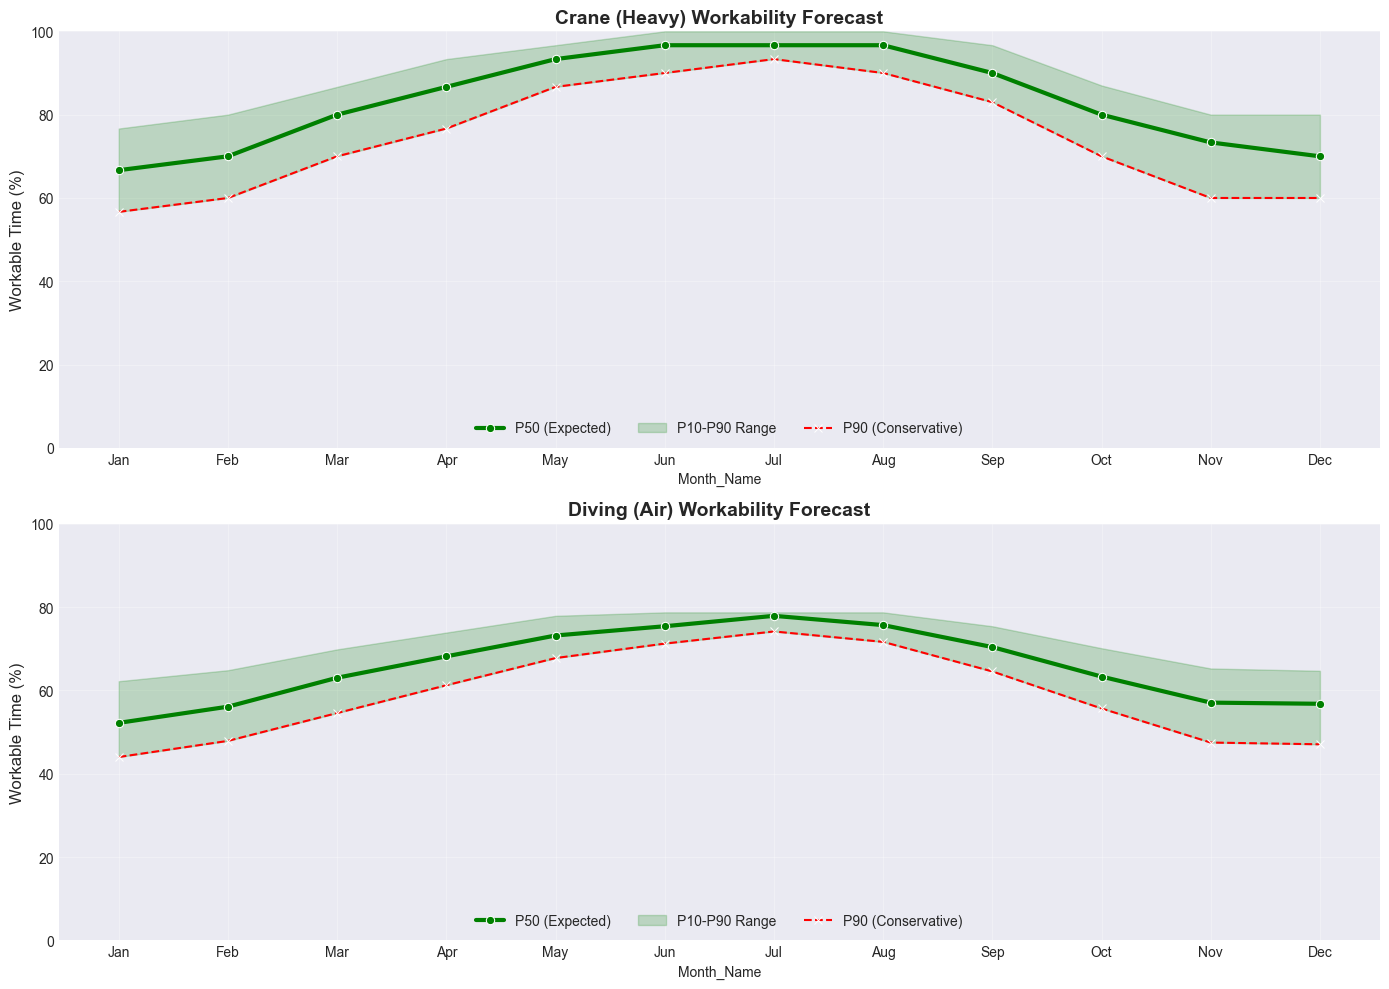


SUMMARY TABLE (Conservative P90 Workability)
Month_Name       Jan   Feb   Mar   Apr   May   Jun    Jul   Aug   Sep   Oct  \
Operation                                                                     
Cable Laying    33.3  36.7  46.7  56.7  73.3  80.0   86.7  80.0  66.7  50.0   
Crane (Heavy)   56.7  60.0  70.0  76.7  86.7  90.0   93.3  90.0  83.0  70.0   
Diving (Air)    44.0  47.9  54.6  61.3  67.8  71.2   74.2  71.7  64.6  55.7   
ROV Operations  83.3  86.7  90.0  93.3  96.7  96.7  100.0  96.7  93.3  90.0   

Month_Name       Nov   Dec  
Operation                   
Cable Laying    40.0  36.7  
Crane (Heavy)   60.0  60.0  
Diving (Air)    47.5  47.1  
ROV Operations  83.3  86.7  

💡 **How to use this table:**
   - These values represent the **Conservative (P90)** workability percentage.
   - You can be 90% confident that the actual workability will be **at least** this high.
   - Use these values for fixed-price tendering to protect against bad weather years.

✅ Phase 5C1 Complet

In [6]:
# ## PART 4: VISUALIZATION

# ### Cell 6: P50/P90 Workability Forecast

print("\n" + "="*80)
print("WORKABILITY FORECAST (P50 vs P90 Risk)")
print("="*80)

# Plot for Crane and Diving
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

for i, op in enumerate(['Crane (Heavy)', 'Diving (Air)']):
    ax = axes[i]
    data = df_res[df_res['Operation'] == op]
    
    # Plot P50
    sns.lineplot(data=data, x='Month_Name', y='P50_Workability', marker='o', linewidth=3, color='green', label='P50 (Expected)', ax=ax)
    
    # Plot Risk Band (P90 Conservative to P10 Optimistic)
    ax.fill_between(data['Month_Name'], data['P90_Workability'], data['P10_Workability'], color='green', alpha=0.2, label='P10-P90 Range')
    
    # Plot P90 Conservative Line explicitly
    sns.lineplot(data=data, x='Month_Name', y='P90_Workability', marker='x', linestyle='--', color='red', label='P90 (Conservative)', ax=ax)
    
    ax.set_title(f'{op} Workability Forecast', fontsize=14, fontweight='bold')
    ax.set_ylabel('Workable Time (%)', fontsize=12)
    ax.set_ylim(0, 100)
    ax.legend(loc='lower center', ncol=3)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# ### Cell 7: Monthly Summary Table

print("\n" + "="*80)
print("SUMMARY TABLE (Conservative P90 Workability)")
print("="*80)

pivot = df_res.pivot(index='Operation', columns='Month_Name', values='P90_Workability')
pivot = pivot[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]

print(pivot.round(1))

print("\n💡 **How to use this table:**")
print("   - These values represent the **Conservative (P90)** workability percentage.")
print("   - You can be 90% confident that the actual workability will be **at least** this high.")
print("   - Use these values for fixed-price tendering to protect against bad weather years.")

print("\n✅ Phase 5C1 Complete.")